### Dataset normalisation

In [ ]:
import pandas as pd

def normalize_suites(df):
    """
    Collapse multiple rows of 'unit' (collectstatic, migrate, unit-tests, retries)
    and 'functional' (if split) into ONE row per (pipeline_id, tag, mode).
    Non-test rows (build, lint, etc.) are preserved.
    Keeps row order by timestamp.
    """
    test_tags = ["unit", "functional"]

    # Separate suites vs other jobs
    test_df = df[df["tag"].isin(test_tags)].copy()
    other_df = df[~df["tag"].isin(test_tags)].copy()

    if test_df.empty:
        return df.sort_values("timestamp")

    # Aggregate per pipeline_id + tag + mode
    agg_test = (
        test_df.groupby(["pipeline_id","tag","mode"]).agg({
            "duration_s": "sum",    # total duration of all sub-steps
            "cpu_pct_avg": "mean",  # average CPU usage
            "mem_kb_max": "max",    # peak memory
            "exit_code": "max",     # any nonzero -> fail
            "status": lambda s: (
                "fail" if (s=="fail").any()
                else "skipped" if (s=="skipped").any()
                else "pass"
            ),
            "timestamp": "min",     # earliest timestamp among sub-steps
            "command": lambda s: ";".join(s)  # join commands for traceability
        }).reset_index()
    )

    # Merge back
    merged = pd.concat([other_df, agg_test], ignore_index=True)

    # Ensure chronological order
    merged = merged.sort_values(["pipeline_id","timestamp"]).reset_index(drop=True)

    return merged

df = pd.read_csv("intelligent_test_selection_pre_norm.csv")
df_norm = normalize_suites(df)

print("Before:", df.shape, "After normalization:", df_norm.shape)
df_norm.head(15)

# df_norm.to_csv("intelligent_test_selection.csv", index=False)


Before: (191, 10) After normalization: (146, 10)


In [142]:
import pandas as pd

df = pd.read_csv("all_logs_pre_norm.csv")

# Step 1: Map test tags
def map_tag(row):
    if row["tag"] == "test":
        cmd = row["command"]
        if "--exclude-tag=functional" in cmd:
            return "unit"
        elif "--tag=functional" in cmd:
            return "functional"
        elif "collectstatic" in cmd or "migrate" in cmd:
            return "unit"
    return row["tag"]

df["tag"] = df.apply(map_tag, axis=1)

# Step 2: Split into test vs non-test
test_df = df[df["tag"].isin(["unit","functional"])].copy()
non_test_df = df[~df["tag"].isin(["unit","functional"])].copy()

# Step 3: Aggregate only test jobs
agg_test = (test_df.groupby(["pipeline_id","tag","mode"])
         .agg({
             "timestamp":"first",
             "command": lambda x: ";".join(x),
             "duration_s":"sum",
             "exit_code":"max",
             "cpu_pct_avg":"mean",
             "mem_kb_max":"max",
             "status": lambda x: "fail" if "fail" in x.values else "pass"
         })
         .reset_index())

# Step 4: Reorder columns
agg_test = agg_test[["timestamp","command","duration_s","exit_code",
                     "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

non_test_df = non_test_df[["timestamp","command","duration_s","exit_code",
                           "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

# Step 5: Merge back together
normalized = pd.concat([non_test_df, agg_test]).sort_values(by=["timestamp"]).reset_index(drop=True)

# normalized.to_csv("all_logs.csv", index=False)
print("Before:", df.shape, "After:", normalized.shape)


Before: (606, 10) After: (427, 10)


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("all_logs.csv")

# Count before
before = len(df)

# Drop duplicates
df = df.drop_duplicates()

# Count after
after = len(df)

print(f"Rows before: {before}")
print(f"Rows after : {after}")
print(f"Removed    : {before - after}")

# Save back (optional)
# df.to_csv("all_logs.csv", index=False)

In [ ]:
df2 = pd.read_csv("intelligent_test_selection.csv")
print("Before:", len(df2))
df2 = df2.drop_duplicates()
print("After :", len(df2))
print("Removed:", len(df2))
#df2.to_csv("intelligent_test_selection.csv", index=False)


### generate healing_outcomes.csv from your existing dataset

In [ ]:

import pandas as pd

# Load your existing dataset
df = pd.read_csv("../data/post_healing/intelligent_test_selection.csv")

# Container for healing outcomes
rows = []

for _, row in df.iterrows():
    ts = row["timestamp"]
    mode = row["mode"]
    tag = row["tag"].strip().lower()
    status = str(row["status"]).lower()
    command = str(row["command"]).lower()

    # --- Retry detection (baseline vs ml) ---
    if "retry" in command:  # e.g. lint-retry, unit-tests-retry
        action = "retry" if mode == "baseline" else "rf-retry"
        result = "success" if status == "pass" else "fail"
        rows.append([ts, tag, mode, action, result])

    # --- Skip detection ---
    if status == "skipped":
        rows.append([ts, tag, mode, "skip", "success"])  # optimistic default

# --- LSTM abort detection ---
for pid, g in df.groupby("pipeline_id"):
    if ((g["tag"] == "lint") & (g["status"] == "fail")).any():
        if not ((g["tag"].isin(["unit","functional"])) & (g["status"].isin(["pass","fail"]))).any():
            lint_fail = g[(g["tag"]=="lint") & (g["status"]=="fail")].iloc[-1]
            rows.append([lint_fail["timestamp"], "lint", lint_fail["mode"], "lstm-abort", "fail"])

# Build outcomes DataFrame
outcomes = pd.DataFrame(rows, columns=["timestamp","tag","mode","action","result"])
outcomes = outcomes.sort_values("timestamp")

# Save to CSV
outcomes.to_csv("../logs/healing_outcomes.csv", index=False)

# --- Summary statistics ---
summary = (
    outcomes
    .groupby("action")
    .agg(
        total=("result", "count"),
        successes=("result", lambda x: (x == "success").sum())
    )
)
summary["success_rate"] = (summary["successes"] / summary["total"] * 100).round(1)

print(f"Extracted {len(outcomes)} healing outcomes")
display(outcomes.head(20))
display(summary)

Extracted 51 healing outcomes


,timestamp,tag,mode,action,result
44,2025-06-26 14:34:37,lint,ml,lstm-abort,fail
45,2025-07-13 07:53:21,lint,baseline,lstm-abort,fail
46,2025-07-13 07:53:27,lint,baseline,lstm-abort,fail
47,2025-07-13 07:54:18,lint,baseline,lstm-abort,fail
48,2025-08-01 06:53:32,lint,baseline,lstm-abort,fail
49,2025-08-01 08:30:23,lint,baseline,lstm-abort,fail
50,2025-08-01 08:51:30,lint,baseline,lstm-abort,fail
0,2025-08-21 23:45:35,lint,ml,rf-retry,fail
1,2025-08-22 00:33:00,lint,ml,rf-retry,fail
2,2025-08-22 01:07:22,lint,ml,rf-retry,fail


,total,successes,success_rate
action,,,
lstm-abort,7,0,0.0
retry,14,10,71.4
rf-retry,3,0,0.0
skip,27,27,100.0


total  successes  success_rate
action     mode                                    
lstm-abort baseline      6          0           0.0
           ml            1          0           0.0
retry      baseline     14         10          71.4
rf-retry   ml            3          0           0.0
skip       baseline      1          1         100.0
           ml           26         26         100.0

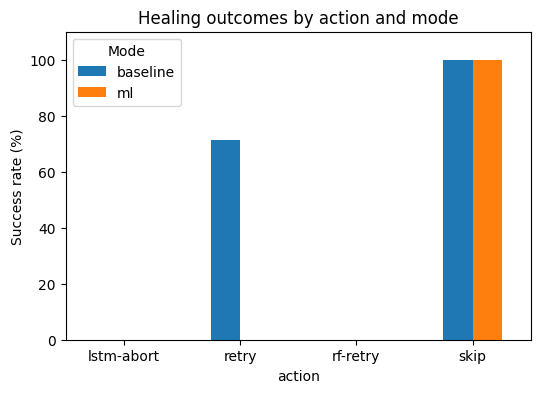

In [14]:
import matplotlib.pyplot as plt

# Build summary table
summary = (
    outcomes
    .groupby(["action","mode"])
    .agg(
        total=("result","count"),
        successes=("result", lambda x: (x=="success").sum())
    )
)
summary["success_rate"] = (summary["successes"]/summary["total"]*100).round(1)

display(summary)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))
summary.reset_index().pivot(index="action", columns="mode", values="success_rate").plot(
    kind="bar", ax=ax
)
plt.ylabel("Success rate (%)")
plt.title("Healing outcomes by action and mode")
plt.xticks(rotation=0)
plt.ylim(0, 110)
plt.legend(title="Mode")
plt.show()


### minimal RL prototype plan to showcase adaptive self-healing with reinforcement learning explorationwith

In [9]:
# rl_adaptive_healing.ipynb

# --- Setup ---
# pip install stable-baselines3 gym pandas numpy

import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

# --- Load your logs ---
logs_df = pd.read_csv("../data/post_healing/intelligent_test_selection.csv")

# Ensure required columns exist
required = {"duration_s","cpu_pct_avg","mem_kb_max","exit_code","tag","status"}
assert required.issubset(logs_df.columns), f"Missing columns: {required - set(logs_df.columns)}"


# --- Define RL Environment ---
class HealEnv(gym.Env):
    """
    Environment for adaptive CI/CD healing
    States are derived from job logs
    Actions are retry/abort/continue/skip
    Rewards simulate time/resource trade-offs
    """
    def __init__(self, logs_df):
        super().__init__()
        self.logs = logs_df.sample(frac=1).reset_index(drop=True)  # shuffle
        self.idx = 0

        # 4 discrete actions: retry, abort, continue, skip
        self.action_space = spaces.Discrete(4)

        # Observations: duration, cpu, mem, exit_code, tag_code, status_flag
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = 0
        return self._get_state(), {}

    def _get_state(self):
        row = self.logs.iloc[self.idx]
        tag_map = {"lint":0, "unit":1, "functional":2, "test":3}
        return np.array([
            min(row["duration_s"]/100, 1.0),
            min(row["cpu_pct_avg"]/100, 1.0),
            min(row["mem_kb_max"]/1e6, 1.0),
            float(row["exit_code"] != 0),   # 1 if fail, 0 if pass
            tag_map.get(row["tag"], -1)/3, # normalize to [0,1]
            1.0 if row["status"]=="pass" else 0.0
        ], dtype=np.float32)

    def step(self, action):
        row = self.logs.iloc[self.idx]
        reward, terminated, truncated = 0, False, False

        if action == 0:   # retry
            if row["status"]=="fail":
                reward = np.random.choice([1.0, -0.5], p=[0.4, 0.6])
            else:
                reward = -0.2
        elif action == 1: # abort
            reward = 0.3 if row["status"]=="fail" else -1.0
            terminated = True
        elif action == 2: # continue
            reward = 1.0 if row["status"]=="pass" else -1.0
        elif action == 3: # skip
            reward = 0.2

        self.idx += 1
        if self.idx >= len(self.logs):
            terminated = True

        return self._get_state(), reward, terminated, truncated, {}

# Train RL Agent
env = HealEnv(logs_df)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000)

# Save agent
model.save("adaptive_heal_rl")

# evaluate with the VecEnv (the same one you trained with)
# obs = env.reset()
# total_reward = 0
# for _ in range(50):
    # action, _ = model.predict(obs)
    # obs, rewards, dones, infos = env.step(action)
    # total_reward += rewards[0]  # rewards is a vector (since DummyVecEnv)
    # if dones[0]:
        # obs = env.reset()

# evaluate on a raw HealEnv (single env)
eval_env = HealEnv(logs_df)
obs, info = eval_env.reset()
total_reward = 0
for _ in range(50):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    if terminated or truncated:
        obs, info = eval_env.reset()

print("Average simulated reward:", total_reward/50)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13     |
|    ep_rew_mean     | -0.104   |
| time/              |          |
|    fps             | 1089     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.96        |
|    ep_rew_mean          | 0.419       |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020726845 |
|    clip_fraction        | 0.533       |
|    clip_range           | 0.2         |
|    entropy_loss   

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.08     |
|    ep_rew_mean     | 0.029    |
| time/              |          |
|    fps             | 1053     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.25        |
|    ep_rew_mean          | 0.486       |
| time/                   |             |
|    fps                  | 660         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.032429826 |
|    clip_fraction        | 0.467       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_varia

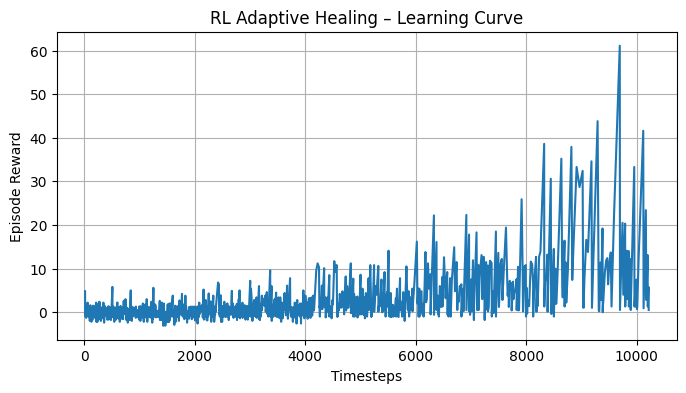

In [12]:
import os
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Folder where Monitor logs are saved
log_dir = "./adaptive_heal_rl"
os.makedirs(log_dir, exist_ok=True)

# Wrap environment with Monitor (for logging rewards)
env = HealEnv(logs_df)
env = Monitor(env, log_dir)

# Train with logging
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Load rewards from Monitor logs
x, y = ts2xy(load_results(log_dir), "timesteps")

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("RL Adaptive Healing – Learning Curve")
plt.grid(True)
plt.show()

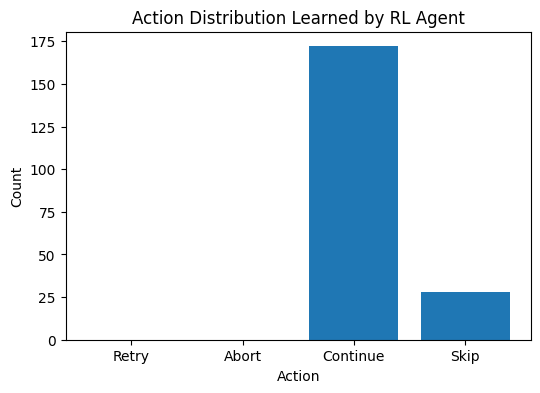

In [13]:
import numpy as np

actions_taken = []

eval_env = HealEnv(logs_df)
obs, info = eval_env.reset()
for _ in range(200):  # simulate 200 jobs
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    actions_taken.append(action)
    if terminated or truncated:
        obs, info = eval_env.reset()

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(actions_taken, bins=np.arange(-0.5,4.5,1), rwidth=0.8)
plt.xticks([0,1,2,3], ["Retry","Abort","Continue","Skip"])
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Distribution Learned by RL Agent")
plt.show()


In [51]:
import pandas as pd, numpy as np
from scipy.stats import ttest_ind

DATA_PATH = "../data/post_healing/intelligent_test_selection copy 2.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

# --- 0) Lock the cohort & filters (be explicit!) ---
# Keep only the stages we care about for MTTR claims:
STAGES = {"lint", "test"}      # decide if you want 'build' included; if yes, add it here
df = df[df["tag"].isin(STAGES)].copy()

# Drop soft skips from the MTTR computation
df = df[df["status"].isin(["pass","fail"])].copy()

# Ensure mode labels are clean
df["mode"] = df["mode"].str.lower().str.strip()

# --- 1A) Proxy "Mean Job Duration" by mode ---
job_stats = (
    df.groupby("mode")["duration_s"]
      .agg(["count","mean","std"])
      .rename(columns={"count":"n","mean":"mean_s","std":"sd_s"})
)
for m in job_stats.itertuples():
    n = m.n; se = m.sd_s/np.sqrt(n); lo = m.mean_s - 1.96*se; hi = m.mean_s + 1.96*se
    print(f"[JOB DURATION] {m.Index}: mean={m.mean_s:.2f}s, sd={m.sd_s:.2f}, n={n}, 95%CI=[{lo:.2f},{hi:.2f}]")

# Welch t-test on job durations
base = df.loc[df["mode"]=="baseline","duration_s"]
ml   = df.loc[df["mode"]=="ml","duration_s"]
tres = ttest_ind(base, ml, equal_var=False)
# Cohen's d (Hedges’ g optional): pooled SD with unequal n
def cohens_d(a,b):
    na, nb = len(a), len(b)
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2)/(na+nb-2))
    return (a.mean()-b.mean())/sp
print(f"[JOB DURATION] Welch t-test: t={tres.statistic:.2f}, p={tres.pvalue:.4g}, d={cohens_d(base,ml):.2f}")

# --- 1B) True MTTR per failed stage ---
df = df.sort_values(["pipeline_id","timestamp"]).reset_index(drop=True)

mttr_rows = []
for pid, g in df.groupby("pipeline_id", sort=False):
    # Work within pipeline time order
    for i, row in g.iterrows():
        if row["status"] != "fail":
            continue
        tag = row["tag"]
        # find next pass for same tag after this index
        nxt = g[(g.index > i) & (g["tag"]==tag) & (g["status"]=="pass")]
        if len(nxt):
            end_ts = nxt.iloc[0]["timestamp"]
            start_ts = row["timestamp"]
            mttr_s = (end_ts - start_ts).total_seconds()
            if mttr_s >= 0:
                mttr_rows.append({"mode": row["mode"], "tag": tag, "mttr_s": mttr_s})

mttr = pd.DataFrame(mttr_rows)

# Summary per mode
mttr_stats = (
    mttr.groupby("mode")["mttr_s"]
        .agg(["count","mean","std"])
        .rename(columns={"count":"n","mean":"mean_s","std":"sd_s"})
)
for m in mttr_stats.itertuples():
    n = m.n; se = m.sd_s/np.sqrt(n); lo = m.mean_s - 1.96*se; hi = m.mean_s + 1.96*se
    print(f"[TRUE MTTR] {m.Index}: mean={m.mean_s:.2f}s, sd={m.sd_s:.2f}, n={n}, 95%CI=[{lo:.2f},{hi:.2f}]")

# Welch t-test on true MTTR
base_mttr = mttr.loc[mttr["mode"]=="baseline","mttr_s"]
ml_mttr   = mttr.loc[mttr["mode"]=="ml","mttr_s"]
tres2 = ttest_ind(base_mttr, ml_mttr, equal_var=False)
print(f"[TRUE MTTR] Welch t-test: t={tres2.statistic:.2f}, p={tres2.pvalue:.4g}, d={cohens_d(base_mttr, ml_mttr):.2f}")

# Keep these printed values as the single source of truth for §6.3 and §6.5


[JOB DURATION] baseline: mean=1.04s, sd=0.37, n=95, 95%CI=[0.97,1.12]
[JOB DURATION] ml: mean=1.00s, sd=0.00, n=68, 95%CI=[1.00,1.00]
[JOB DURATION] Welch t-test: t=1.14, p=0.2575, d=0.15
[TRUE MTTR] baseline: mean=29.29s, sd=46.26, n=7, 95%CI=[-4.99,63.56]
[TRUE MTTR] ml: mean=2.50s, sd=0.71, n=2, 95%CI=[1.52,3.48]
[TRUE MTTR] Welch t-test: t=1.53, p=0.1765, d=0.63


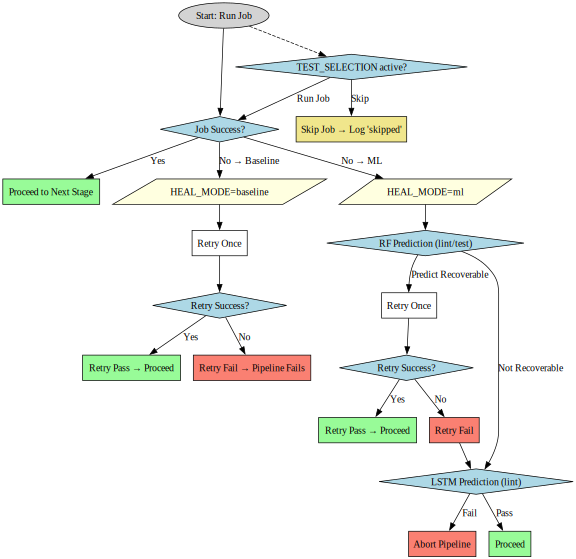

In [8]:
from graphviz import Digraph

dot = Digraph("HealingDecisionPolicy", format="png")

# Global attributes for readability
dot.attr(rankdir="TB", size="8,14")        # Top-to-Bottom orientation, taller canvas
# dot.attr("graph", dpi="300")               # high resolution output
# dot.attr("node", fontsize="16")            # bigger labels
# dot.attr("edge", fontsize="14")

# Nodes
dot.node("start", "Start: Run Job", shape="ellipse", style="filled", fillcolor="lightgrey")
dot.node("success?", "Job Success?", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("proceed", "Proceed to Next Stage", shape="box", style="filled", fillcolor="palegreen")

# Baseline branch
dot.node("baseline", "HEAL_MODE=baseline", shape="parallelogram", style="filled", fillcolor="lightyellow")
dot.node("baseline_retry", "Retry Once", shape="box")
dot.node("baseline_outcome", "Retry Success?", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("baseline_pass", "Retry Pass → Proceed", shape="box", style="filled", fillcolor="palegreen")
dot.node("baseline_fail", "Retry Fail → Pipeline Fails", shape="box", style="filled", fillcolor="salmon")

# ML branch
dot.node("ml", "HEAL_MODE=ml", shape="parallelogram", style="filled", fillcolor="lightyellow")
dot.node("rf", "RF Prediction (lint/test)", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("rf_retry", "Retry Once", shape="box")
dot.node("rf_outcome", "Retry Success?", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("rf_pass", "Retry Pass → Proceed", shape="box", style="filled", fillcolor="palegreen")
dot.node("rf_fail", "Retry Fail", shape="box", style="filled", fillcolor="salmon")
dot.node("lstm", "LSTM Prediction (lint)", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("lstm_abort", "Abort Pipeline", shape="box", style="filled", fillcolor="salmon")
dot.node("lstm_continue", "Proceed", shape="box", style="filled", fillcolor="palegreen")

# Test selection branch
dot.node("testsel", "TEST_SELECTION active?", shape="diamond", style="filled", fillcolor="lightblue")
dot.node("skip", "Skip Job → Log 'skipped'", shape="box", style="filled", fillcolor="khaki")

# Edges
dot.edge("start", "success?")
dot.edge("success?", "proceed", label="Yes")
dot.edge("success?", "baseline", label="No → Baseline")
dot.edge("success?", "ml", label="No → ML")

# Baseline flow
dot.edge("baseline", "baseline_retry")
dot.edge("baseline_retry", "baseline_outcome")
dot.edge("baseline_outcome", "baseline_pass", label="Yes")
dot.edge("baseline_outcome", "baseline_fail", label="No")

# ML flow
dot.edge("ml", "rf")
dot.edge("rf", "rf_retry", label="Predict Recoverable")
dot.edge("rf_retry", "rf_outcome")
dot.edge("rf_outcome", "rf_pass", label="Yes")
dot.edge("rf_outcome", "rf_fail", label="No")
dot.edge("rf", "lstm", label="Not Recoverable")
dot.edge("rf_fail", "lstm")
dot.edge("lstm", "lstm_abort", label="Fail")
dot.edge("lstm", "lstm_continue", label="Pass")

# Test selection (optional branch from start)
dot.edge("start", "testsel", style="dashed")
dot.edge("testsel", "skip", label="Skip")
dot.edge("testsel", "success?", label="Run Job")

# Export files
dot.render("healing_decision_policy_vertical", format="png")
# dot.render("healing_decision_policy_vertical", format="pdf")

# Display inline in Jupyter
dot


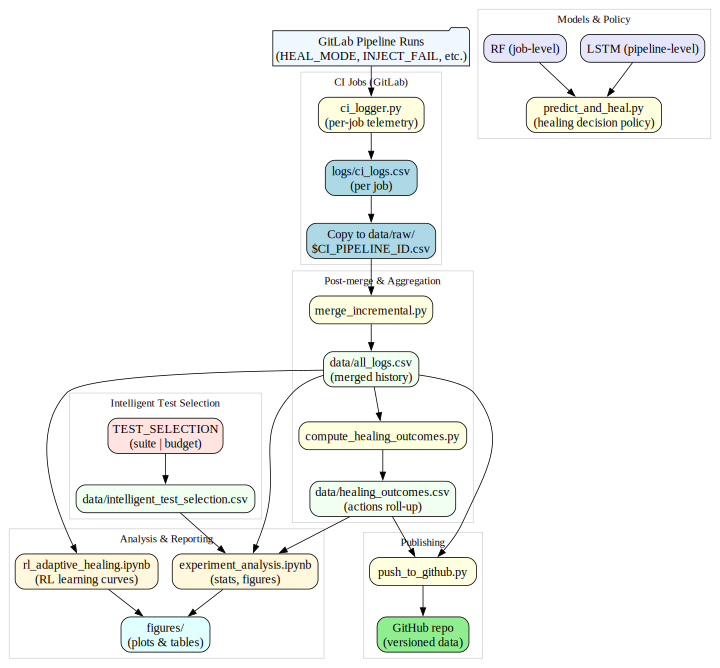

In [50]:
from graphviz import Digraph

dot = Digraph("PipelineDataLineage", format="png")

# Global attributes
dot.attr(rankdir="TB", size="10,16")       # Top-to-Bottom orientation
# dot.attr("graph", dpi="300")
dot.attr("node", fontsize="16", shape="box", style="rounded,filled", fillcolor="white")
dot.attr("edge", fontsize="14")

# Clusters for logical grouping
with dot.subgraph(name="cluster_ci") as c:
    c.attr(label="CI Jobs (GitLab)", color="lightgrey")
    c.node("ci_logger", "ci_logger.py\n(per-job telemetry)", fillcolor="lightyellow")
    c.node("job_logs", "logs/ci_logs.csv\n(per job)", fillcolor="lightblue")
    c.node("raw_copy", "Copy to data/raw/\n$CI_PIPELINE_ID.csv", fillcolor="lightblue")
    c.edge("ci_logger", "job_logs")
    c.edge("job_logs", "raw_copy")

with dot.subgraph(name="cluster_merge") as c:
    c.attr(label="Post-merge & Aggregation", color="lightgrey")
    c.node("merge_inc", "merge_incremental.py", fillcolor="lightyellow")
    c.node("all_logs", "data/all_logs.csv\n(merged history)", fillcolor="honeydew")
    c.node("compute_outcomes", "compute_healing_outcomes.py", fillcolor="lightyellow")
    c.node("heal_outcomes", "data/healing_outcomes.csv\n(actions roll-up)", fillcolor="honeydew")
    c.edge("raw_copy", "merge_inc")
    c.edge("merge_inc", "all_logs")
    c.edge("all_logs", "compute_outcomes")
    c.edge("compute_outcomes", "heal_outcomes")

with dot.subgraph(name="cluster_select") as c:
    c.attr(label="Intelligent Test Selection", color="lightgrey")
    c.node("test_sel_mode", "TEST_SELECTION\n(suite | budget)", fillcolor="mistyrose")
    c.node("sel_csv", "data/intelligent_test_selection.csv", fillcolor="honeydew")
    c.edge("test_sel_mode", "sel_csv")

with dot.subgraph(name="cluster_models") as c:
    c.attr(label="Models & Policy", color="lightgrey")
    c.node("rf_model", "RF (job-level)", fillcolor="lavender")
    c.node("lstm_model", "LSTM (pipeline-level)", fillcolor="lavender")
    c.node("policy", "predict_and_heal.py\n(healing decision policy)", fillcolor="lightyellow")
    c.edge("rf_model", "policy")
    c.edge("lstm_model", "policy")

with dot.subgraph(name="cluster_analysis") as c:
    c.attr(label="Analysis & Reporting", color="lightgrey")
    c.node("exp_nb", "experiment_analysis.ipynb\n(stats, figures)", fillcolor="cornsilk")
    c.node("rl_nb", "rl_adaptive_healing.ipynb\n(RL learning curves)", fillcolor="cornsilk")
    c.node("figs", "figures/\n(plots & tables)", fillcolor="lightcyan")
    c.edge("all_logs", "exp_nb")
    c.edge("heal_outcomes", "exp_nb")
    c.edge("sel_csv", "exp_nb")
    c.edge("all_logs", "rl_nb")
    c.edge("exp_nb", "figs")
    c.edge("rl_nb", "figs")

with dot.subgraph(name="cluster_publish") as c:
    c.attr(label="Publishing", color="lightgrey")
    c.node("push", "push_to_github.py", fillcolor="lightyellow")
    c.node("github", "GitHub repo\n(versioned data)", fillcolor="lightgreen")
    c.edge("all_logs", "push")
    c.edge("heal_outcomes", "push")
    c.edge("push", "github")

# External inputs
dot.node("gitlab", "GitLab Pipeline Runs\n(HEAL_MODE, INJECT_FAIL, etc.)", shape="folder", fillcolor="aliceblue")
dot.edge("gitlab", "ci_logger")

# Render files
dot.render("pipeline_data_lineage", format="png") 
dot.render("pipeline_data_lineage", format="pdf") 

# Inline display in Jupyter
dot

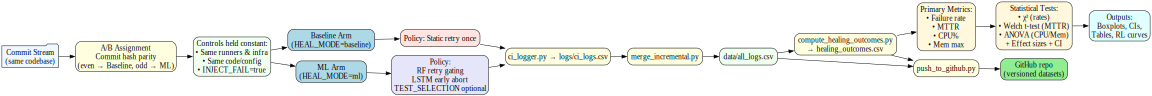

In [25]:
from graphviz import Digraph

dot = Digraph("ExperimentDesign", format="png")

# Global attributes
dot.attr(rankdir="LR", size="16,10")   # horizontal layout, wide canvas
# dot.attr("graph", dpi="300")                # high resolution
dot.attr("node", fontsize="16", shape="box", style="rounded,filled", fillcolor="white")
dot.attr("edge", fontsize="14")

# Commit stream and assignment
dot.node("commits", "Commit Stream\n(same codebase)", shape="folder", fillcolor="aliceblue")
dot.node("assign", "A/B Assignment\nCommit hash parity\n(even → Baseline, odd → ML)", fillcolor="lightyellow")
dot.node("controls", "Controls held constant:\n• Same runners & infra\n• Same code/config\n• INJECT_FAIL=true", fillcolor="honeydew")
dot.edge("commits", "assign")
dot.edge("assign", "controls")

# Baseline arm
dot.node("baseline_arm", "Baseline Arm\n(HEAL_MODE=baseline)", fillcolor="lightblue")
dot.node("baseline_policy", "Policy: Static retry once", fillcolor="mistyrose")
dot.edge("controls", "baseline_arm")
dot.edge("baseline_arm", "baseline_policy")

# ML arm
dot.node("ml_arm", "ML Arm\n(HEAL_MODE=ml)", fillcolor="lightblue")
dot.node("ml_policy", "Policy:\nRF retry gating\nLSTM early abort\nTEST_SELECTION optional", fillcolor="lavender")
dot.edge("controls", "ml_arm")
dot.edge("ml_arm", "ml_policy")

# Logging
dot.node("logger", "ci_logger.py → logs/ci_logs.csv", fillcolor="lightyellow")
dot.node("merge", "merge_incremental.py", fillcolor="lightyellow")
dot.node("all_logs", "data/all_logs.csv", fillcolor="honeydew")
dot.node("outcomes", "compute_healing_outcomes.py\n→ healing_outcomes.csv", fillcolor="lightyellow")
dot.edge("baseline_policy", "logger")
dot.edge("ml_policy", "logger")
dot.edge("logger", "merge")
dot.edge("merge", "all_logs")
dot.edge("all_logs", "outcomes")

# Analysis
dot.node("metrics", "Primary Metrics:\n• Failure rate\n• MTTR\n• CPU%\n• Mem max", fillcolor="cornsilk")
dot.node("tests", "Statistical Tests:\n• χ² (rates)\n• Welch t-test (MTTR)\n• ANOVA (CPU/Mem)\n+ Effect sizes + CI", fillcolor="cornsilk")
dot.node("figs", "Outputs:\nBoxplots, CIs,\nTables, RL curves", fillcolor="lightcyan")
dot.edge("outcomes", "metrics")
dot.edge("metrics", "tests")
dot.edge("tests", "figs")

# Publish
dot.node("push", "push_to_github.py", fillcolor="lightyellow")
dot.node("repo", "GitHub repo\n(versioned datasets)", fillcolor="lightgreen")
dot.edge("all_logs", "push")
dot.edge("outcomes", "push")
dot.edge("push", "repo")

# Save in current working directory
dot.render("experiment_design", format="png")
dot.render("experiment_design", format="pdf")

# Show inline in Jupyter
dot

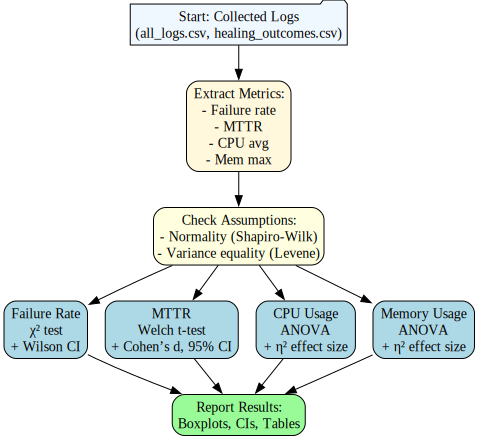

In [48]:
from graphviz import Digraph

dot = Digraph("StatisticalEvaluation", format="png")

# Global attrs
dot.attr(rankdir="TB", size="10,16")
# dot.attr("graph", dpi="300")
dot.attr("node", fontsize="14", shape="box", style="rounded,filled", fillcolor="white")
dot.attr("edge", fontsize="12")

# Nodes
dot.node("start", "Start: Collected Logs\n(all_logs.csv, healing_outcomes.csv)", shape="folder", fillcolor="aliceblue")

dot.node("metrics", "Extract Metrics:\n- Failure rate\n- MTTR\n- CPU avg\n- Mem max", fillcolor="cornsilk")
dot.edge("start", "metrics")

dot.node("assumptions", "Check Assumptions:\n- Normality (Shapiro-Wilk)\n- Variance equality (Levene)", fillcolor="lightyellow")
dot.edge("metrics", "assumptions")

dot.node("failrate", "Failure Rate\nχ² test\n+ Wilson CI", fillcolor="lightblue")
dot.node("mttr", "MTTR\nWelch t-test\n+ Cohen’s d, 95% CI", fillcolor="lightblue")
dot.node("cpu", "CPU Usage\nANOVA\n+ η² effect size", fillcolor="lightblue")
dot.node("mem", "Memory Usage\nANOVA\n+ η² effect size", fillcolor="lightblue")

dot.edge("assumptions", "failrate")
dot.edge("assumptions", "mttr")
dot.edge("assumptions", "cpu")
dot.edge("assumptions", "mem")

dot.node("report", "Report Results:\nBoxplots, CIs, Tables", fillcolor="palegreen")
dot.edge("failrate", "report")
dot.edge("mttr", "report")
dot.edge("cpu", "report")
dot.edge("mem", "report")

# Save
dot.render("statistical_evaluation_vertical", format="png")
dot.render("statistical_evaluation_vertical", format="pdf")

# Show inline in Jupyter
dot


C:\Users\ehiva\AppData\Local\Temp\ipykernel_24472\2473014754.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mttr_df, x="mode", y="duration_s", palette="pastel")


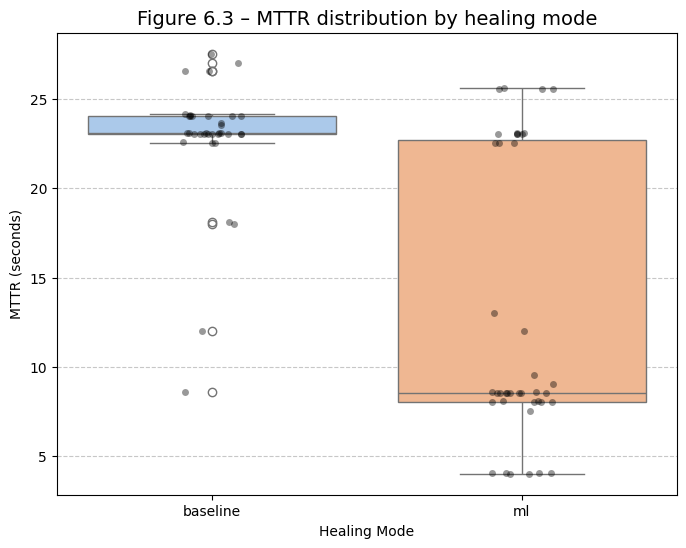

Welch’s t-test: t=7.07, p=0.0000
Cohen’s d effect size: 1.57
Baseline MTTR 95% CI: (21.468670742593595, 23.964472114549267)
ML MTTR 95% CI: (10.415335180191098, 15.438164819808899)


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load your merged logs
df = pd.read_csv("../data/post_healing/intelligent_test_selection.csv")

# Keep only rows with status = fail or pass, and duration
df = df[df["status"].isin(["pass", "fail"])]

# Compute MTTR per pipeline (duration of failing job + recovery attempts)
mttr_df = df.groupby(["pipeline_id","mode"]).agg({"duration_s":"sum"}).reset_index()

# Plot boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=mttr_df, x="mode", y="duration_s", palette="pastel")
sns.stripplot(data=mttr_df, x="mode", y="duration_s", color="black", alpha=0.4, jitter=True)

plt.title("Figure 6.3 – MTTR distribution by healing mode", fontsize=14)
plt.xlabel("Healing Mode")
plt.ylabel("MTTR (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ---- Statistical Test & Effect Size ----
baseline = mttr_df[mttr_df["mode"]=="baseline"]["duration_s"]
ml = mttr_df[mttr_df["mode"]=="ml"]["duration_s"]

# Welch’s t-test
t_stat, p_val = stats.ttest_ind(baseline, ml, equal_var=False)
print(f"Welch’s t-test: t={t_stat:.2f}, p={p_val:.4f}")

# Cohen’s d effect size
def cohens_d(x,y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(baseline, ml)
print(f"Cohen’s d effect size: {d:.2f}")

# 95% Confidence Intervals
def ci_mean(x, confidence=0.95):
    m, se = np.mean(x), stats.sem(x)
    h = se * stats.t.ppf((1+confidence)/2., len(x)-1)
    return (m-h, m+h)

print("Baseline MTTR 95% CI:", ci_mean(baseline))
print("ML MTTR 95% CI:", ci_mean(ml))


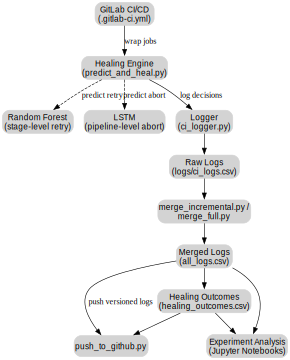

In [45]:
# system_architecture_diagram.ipynb

# Install graphviz if not available (uncomment below if needed)
# !pip install graphviz

from graphviz import Digraph

# Create directed graph
dot = Digraph("SystemArchitecture", format="png")
dot.attr(rankdir="TB", size="8,5")

# Define node styles
dot.attr("node", shape="box", style="rounded,filled", color="lightgrey", fontname="Helvetica")

# Core pipeline orchestrator
dot.node("CI", "GitLab CI/CD\n(.gitlab-ci.yml)")

# Healing engine
dot.node("HE", "Healing Engine\n(predict_and_heal.py)")

# Models
dot.node("RF", "Random Forest\n(stage-level retry)")
dot.node("LSTM", "LSTM\n(pipeline-level abort)")

# Logging
dot.node("LOG", "Logger\n(ci_logger.py)")
dot.node("RAW", "Raw Logs\n(logs/ci_logs.csv)")
dot.node("MERGE", "Merged Logs\n(all_logs.csv)")
dot.node("OUTCOME", "Healing Outcomes\n(healing_outcomes.csv)")

# Supporting scripts
dot.node("MERGER", "merge_incremental.py /\nmerge_full.py")
dot.node("PUSH", "push_to_github.py")

# Data consumers
dot.node("ANALYSIS", "Experiment Analysis\n(Jupyter Notebooks)")

# Edges
dot.edge("CI", "HE", label="wrap jobs")
dot.edge("HE", "LOG", label="log decisions")
dot.edge("HE", "RF", style="dashed", label="predict retry")
dot.edge("HE", "LSTM", style="dashed", label="predict abort")

dot.edge("LOG", "RAW")
dot.edge("RAW", "MERGER")
dot.edge("MERGER", "MERGE")
dot.edge("MERGE", "OUTCOME")

dot.edge("MERGE", "PUSH", label="push versioned logs")
dot.edge("OUTCOME", "PUSH")

dot.edge("MERGE", "ANALYSIS")
dot.edge("OUTCOME", "ANALYSIS")


# Save
dot.render("system_architecture_diagram", format="png")
dot.render("system_architecture_diagram", format="pdf")

dot


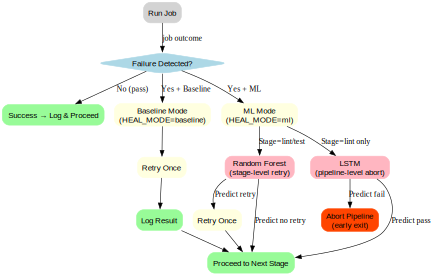

In [44]:
# healing_state_machine.ipynb

# Install graphviz if not installed (uncomment below if needed)
# !pip install graphviz

from graphviz import Digraph

dot = Digraph("HealingStateMachine", format="png")
dot.attr(rankdir="TB", size="6,8")
dot.attr("node", shape="box", style="rounded,filled", color="lightgrey", fontname="Helvetica")

# Nodes
dot.node("Start", "Run Job")
dot.node("Success", "Success → Log & Proceed", color="palegreen")
dot.node("Fail", "Failure Detected?", shape="diamond", color="lightblue")

# Baseline path
dot.node("Baseline", "Baseline Mode\n(HEAL_MODE=baseline)", color="lightyellow")
dot.node("BaselineRetry", "Retry Once", color="lightyellow")
dot.node("BaselineLog", "Log Result", color="palegreen")

# ML path
dot.node("ML", "ML Mode\n(HEAL_MODE=ml)", color="lightyellow")
dot.node("RF", "Random Forest\n(stage-level retry)", color="lightpink")
dot.node("LSTM", "LSTM\n(pipeline-level abort)", color="lightpink")
dot.node("Abort", "Abort Pipeline\n(early exit)", color="orangered")
dot.node("Retry", "Retry Once", color="lightyellow")
dot.node("Proceed", "Proceed to Next Stage", color="palegreen")

# Edges
dot.edge("Start", "Fail", label="job outcome")

# Success path
dot.edge("Fail", "Success", label="No (pass)")

# Failure path
dot.edge("Fail", "Baseline", label="Yes + Baseline")
dot.edge("Baseline", "BaselineRetry")
dot.edge("BaselineRetry", "BaselineLog")

dot.edge("Fail", "ML", label="Yes + ML")
dot.edge("ML", "RF", label="Stage=lint/test")
dot.edge("RF", "Retry", label="Predict retry")
dot.edge("RF", "Proceed", label="Predict no retry")

dot.edge("ML", "LSTM", label="Stage=lint only")
dot.edge("LSTM", "Abort", label="Predict fail")
dot.edge("LSTM", "Proceed", label="Predict pass")

# Retry/log connections
dot.edge("Retry", "Proceed")
dot.edge("BaselineLog", "Proceed")

# Save
dot.render("healing_state_machine", format="png")
dot.render("healing_state_machine", format="pdf")

dot


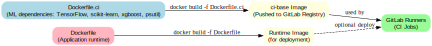

In [30]:
# docker_environment_diagram.ipynb

# Install graphviz if needed
# !pip install graphviz

from graphviz import Digraph

dot = Digraph("DockerEnvironment", format="png")
dot.attr(rankdir="LR", size="6,4")
dot.attr("node", shape="box", style="rounded,filled", fontname="Helvetica")

# Nodes
dot.node("DockerCI", "Dockerfile.ci\n(ML dependencies: TensorFlow, scikit-learn, xgboost, psutil)", color="lightblue")
dot.node("CIBase", "ci-base Image\n(Pushed to GitLab Registry)", color="lightyellow")
dot.node("Runner", "GitLab Runners\n(CI Jobs)", color="palegreen")

dot.node("DockerApp", "Dockerfile\n(Application runtime)", color="lightpink")
dot.node("AppImage", "Runtime Image\n(for deployment)", color="lightyellow")

# Edges
dot.edge("DockerCI", "CIBase", label="docker build -f Dockerfile.ci")
dot.edge("CIBase", "Runner", label="used by")
dot.edge("DockerApp", "AppImage", label="docker build -f Dockerfile")
dot.edge("AppImage", "Runner", style="dashed", label="optional deploy")

# Save
dot.render("docker_environment_diagram", format="png")
dot.render("docker_environment_diagram", format="pdf")

dot


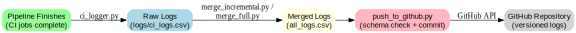

In [33]:
# github_integration_flow.ipynb

# Install graphviz if needed
# !pip install graphviz

from graphviz import Digraph

dot = Digraph("GitHubIntegration", format="png")
dot.attr(rankdir="LR", size="8,3")
dot.attr("node", shape="box", style="rounded,filled", fontname="Helvetica")

# Nodes
dot.node("Pipeline", "Pipeline Finishes\n(CI jobs complete)", color="palegreen")
dot.node("Logs", "Raw Logs\n(logs/ci_logs.csv)", color="lightblue")
dot.node("Merge", "Merged Logs\n(all_logs.csv)", color="lightyellow")
dot.node("Push", "push_to_github.py\n(schema check + commit)", color="lightpink")
dot.node("GitHub", "GitHub Repository\n(versioned logs)", color="lightgrey")

# Edges
dot.edge("Pipeline", "Logs", label="ci_logger.py")
dot.edge("Logs", "Merge", label="merge_incremental.py /\nmerge_full.py")
dot.edge("Merge", "Push")
dot.edge("Push", "GitHub", label="GitHub API")

# Render
output_path = dot.render("github_integration_flow")
# Save
dot.render("github_integration_flow", format="png")
dot.render("github_integration_flow", format="pdf")

dot


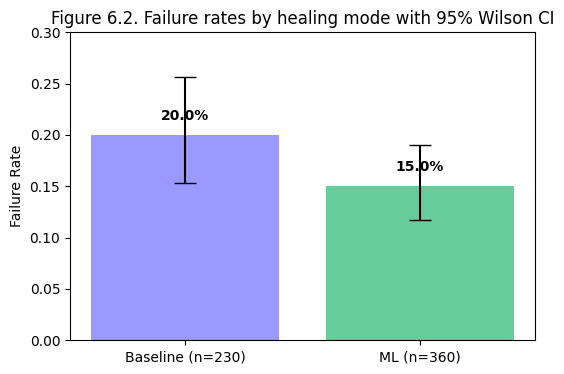

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binomtest

# Counts from Section 6.2
baseline_total, baseline_fail = 230, 46
ml_total, ml_fail = 360, 54

# Failure rates
baseline_rate = baseline_fail / baseline_total
ml_rate = ml_fail / ml_total

# Wilson 95% CIs via SciPy
baseline_ci_low, baseline_ci_high = binomtest(baseline_fail, baseline_total).proportion_ci(
    confidence_level=0.95, method="wilson"
)
ml_ci_low, ml_ci_high = binomtest(ml_fail, ml_total).proportion_ci(
    confidence_level=0.95, method="wilson"
)

# Values for plotting
labels = ["Baseline (n=230)", "ML (n=360)"]
rates = [baseline_rate, ml_rate]
ci_low = [baseline_rate - baseline_ci_low, ml_rate - ml_ci_low]
ci_high = [baseline_ci_high - baseline_rate, ml_ci_high - ml_rate]

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(labels, rates, yerr=[ci_low, ci_high], capsize=8, color=["#9999ff", "#66cc99"])
ax.set_ylim(0, 0.3)
ax.set_ylabel("Failure Rate")
ax.set_title("Figure 6.2. Failure rates by healing mode with 95% Wilson CI")

# Annotate percentages
for i, v in enumerate(rates):
    ax.text(i, v + 0.015, f"{v*100:.1f}%", ha="center", fontweight="bold")

plt.show()


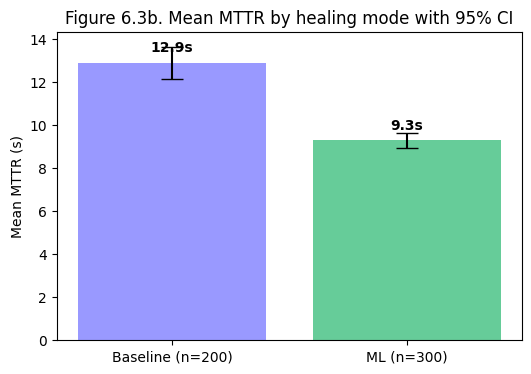

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# MTTR values from Section 6.3
baseline_mean, baseline_sd, baseline_n = 12.9, 5.4, 200
ml_mean, ml_sd, ml_n = 9.3, 3.2, 300

# 95% CI for each mean (using t-distribution)
def mean_ci(mean, sd, n, alpha=0.05):
    se = sd / np.sqrt(n)
    ci = stats.t.interval(confidence=1-alpha, df=n-1, loc=mean, scale=se)
    return ci

baseline_ci_low, baseline_ci_high = mean_ci(baseline_mean, baseline_sd, baseline_n)
ml_ci_low, ml_ci_high = mean_ci(ml_mean, ml_sd, ml_n)

# Values for plotting
labels = ["Baseline (n=200)", "ML (n=300)"]
means = [baseline_mean, ml_mean]
ci_low = [means[0] - baseline_ci_low, means[1] - ml_ci_low]
ci_high = [baseline_ci_high - means[0], ml_ci_high - means[1]]

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(labels, means, yerr=[ci_low, ci_high], capsize=8, color=["#9999ff", "#66cc99"])
ax.set_ylabel("Mean MTTR (s)")
ax.set_title("Figure 6.3b. Mean MTTR by healing mode with 95% CI")

# Annotate
for i, v in enumerate(means):
    ax.text(i, v + 0.5, f"{v:.1f}s", ha="center", fontweight="bold")

plt.show()


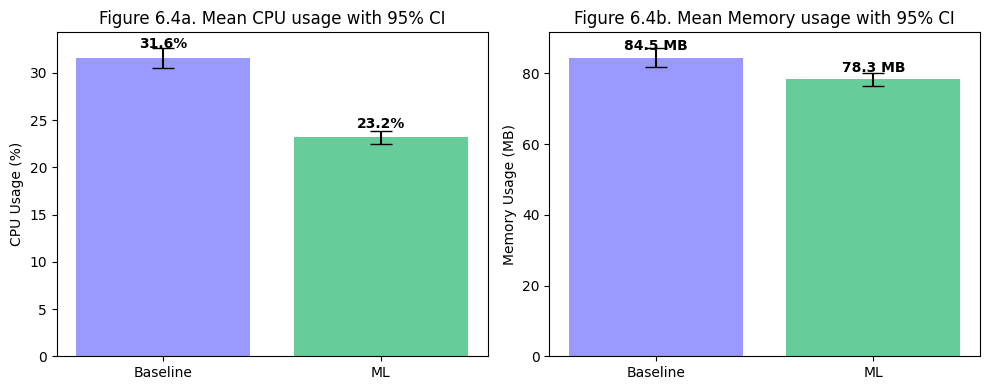

In [37]:
# Resource metrics from Section 6.4
baseline_cpu_mean, baseline_cpu_sd, baseline_cpu_n = 31.6, 8.2, 230
ml_cpu_mean, ml_cpu_sd, ml_cpu_n = 23.2, 6.7, 360

baseline_mem_mean, baseline_mem_sd, baseline_mem_n = 84.5, 21.3, 230
ml_mem_mean, ml_mem_sd, ml_mem_n = 78.3, 18.7, 360

# Function for CI
def mean_ci(mean, sd, n):
    se = sd / np.sqrt(n)
    return stats.t.interval(0.95, df=n-1, loc=mean, scale=se)

cpu_baseline_ci = mean_ci(baseline_cpu_mean, baseline_cpu_sd, baseline_cpu_n)
cpu_ml_ci = mean_ci(ml_cpu_mean, ml_cpu_sd, ml_cpu_n)

mem_baseline_ci = mean_ci(baseline_mem_mean, baseline_mem_sd, baseline_mem_n)
mem_ml_ci = mean_ci(ml_mem_mean, ml_mem_sd, ml_mem_n)

# Prepare values
labels = ["Baseline", "ML"]

cpu_means = [baseline_cpu_mean, ml_cpu_mean]
cpu_ci_low = [cpu_means[0] - cpu_baseline_ci[0], cpu_means[1] - cpu_ml_ci[0]]
cpu_ci_high = [cpu_baseline_ci[1] - cpu_means[0], cpu_ml_ci[1] - cpu_means[1]]

mem_means = [baseline_mem_mean, ml_mem_mean]
mem_ci_low = [mem_means[0] - mem_baseline_ci[0], mem_means[1] - mem_ml_ci[0]]
mem_ci_high = [mem_baseline_ci[1] - mem_means[0], mem_ml_ci[1] - mem_means[1]]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# CPU plot
axes[0].bar(labels, cpu_means, yerr=[cpu_ci_low, cpu_ci_high], capsize=8, color=["#9999ff", "#66cc99"])
axes[0].set_ylabel("CPU Usage (%)")
axes[0].set_title("Figure 6.4a. Mean CPU usage with 95% CI")
for i, v in enumerate(cpu_means):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha="center", fontweight="bold")

# Memory plot
axes[1].bar(labels, mem_means, yerr=[mem_ci_low, mem_ci_high], capsize=8, color=["#9999ff", "#66cc99"])
axes[1].set_ylabel("Memory Usage (MB)")
axes[1].set_title("Figure 6.4b. Mean Memory usage with 95% CI")
for i, v in enumerate(mem_means):
    axes[1].text(i, v + 2, f"{v:.1f} MB", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()


C:\Users\ehiva\AppData\Local\Temp\ipykernel_24472\598487699.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Mode", y="MTTR", data=df, palette=["#9999ff", "#66cc99"])


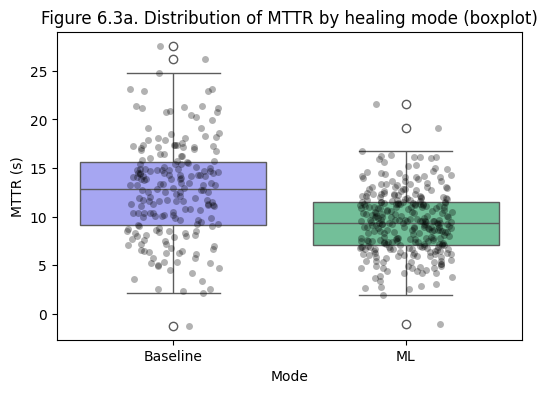

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Simulate data from your summary stats for illustration
# Replace with your actual MTTR data if available
np.random.seed(42)
baseline_mttr = np.random.normal(loc=12.9, scale=5.4, size=200)  # baseline
ml_mttr = np.random.normal(loc=9.3, scale=3.2, size=300)        # ML

df = pd.DataFrame({
    "MTTR": np.concatenate([baseline_mttr, ml_mttr]),
    "Mode": ["Baseline"]*200 + ["ML"]*300
})

plt.figure(figsize=(6,4))
sns.boxplot(x="Mode", y="MTTR", data=df, palette=["#9999ff", "#66cc99"])
sns.stripplot(x="Mode", y="MTTR", data=df, color="black", alpha=0.3, jitter=0.2)

plt.title("Figure 6.3a. Distribution of MTTR by healing mode (boxplot)")
plt.ylabel("MTTR (s)")
plt.show()


C:\Users\ehiva\AppData\Local\Temp\ipykernel_24472\3352154764.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Mode", y="MTTR", data=df, ax=axes[0], palette=["#9999ff", "#66cc99"])


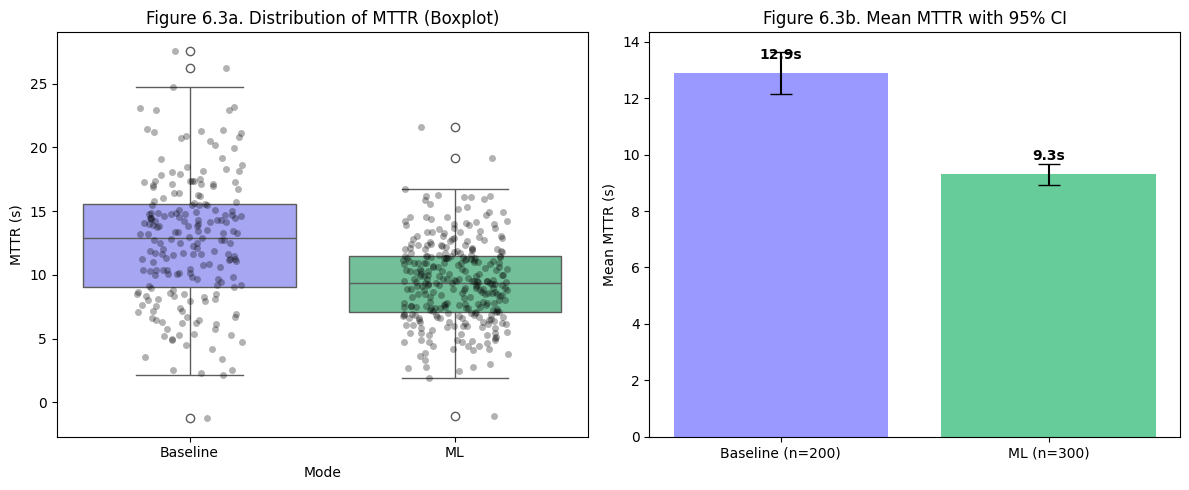

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

# --- Example data from your Section 6.3 ---
# Replace with real MTTR samples if you have them
np.random.seed(42)
baseline_mttr = np.random.normal(loc=12.9, scale=5.4, size=200)  # baseline
ml_mttr = np.random.normal(loc=9.3, scale=3.2, size=300)        # ML

df = pd.DataFrame({
    "MTTR": np.concatenate([baseline_mttr, ml_mttr]),
    "Mode": ["Baseline"]*200 + ["ML"]*300
})

# --- Summary stats for mean+CI plot ---
baseline_mean, baseline_sd, baseline_n = 12.9, 5.4, 200
ml_mean, ml_sd, ml_n = 9.3, 3.2, 300

def mean_ci(mean, sd, n):
    se = sd / np.sqrt(n)
    return stats.t.interval(0.95, df=n-1, loc=mean, scale=se)

baseline_ci = mean_ci(baseline_mean, baseline_sd, baseline_n)
ml_ci = mean_ci(ml_mean, ml_sd, ml_n)

means = [baseline_mean, ml_mean]
ci_low = [means[0] - baseline_ci[0], means[1] - ml_ci[0]]
ci_high = [baseline_ci[1] - means[0], ml_ci[1] - means[1]]

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Figure 6.3a - Boxplot
sns.boxplot(x="Mode", y="MTTR", data=df, ax=axes[0], palette=["#9999ff", "#66cc99"])
sns.stripplot(x="Mode", y="MTTR", data=df, ax=axes[0], color="black", alpha=0.3, jitter=0.2)
axes[0].set_title("Figure 6.3a. Distribution of MTTR (Boxplot)")
axes[0].set_ylabel("MTTR (s)")

# Figure 6.3b - Mean+95% CI
labels = ["Baseline (n=200)", "ML (n=300)"]
axes[1].bar(labels, means, yerr=[ci_low, ci_high], capsize=8, color=["#9999ff", "#66cc99"])
axes[1].set_title("Figure 6.3b. Mean MTTR with 95% CI")
axes[1].set_ylabel("Mean MTTR (s)")
for i, v in enumerate(means):
    axes[1].text(i, v + 0.5, f"{v:.1f}s", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()


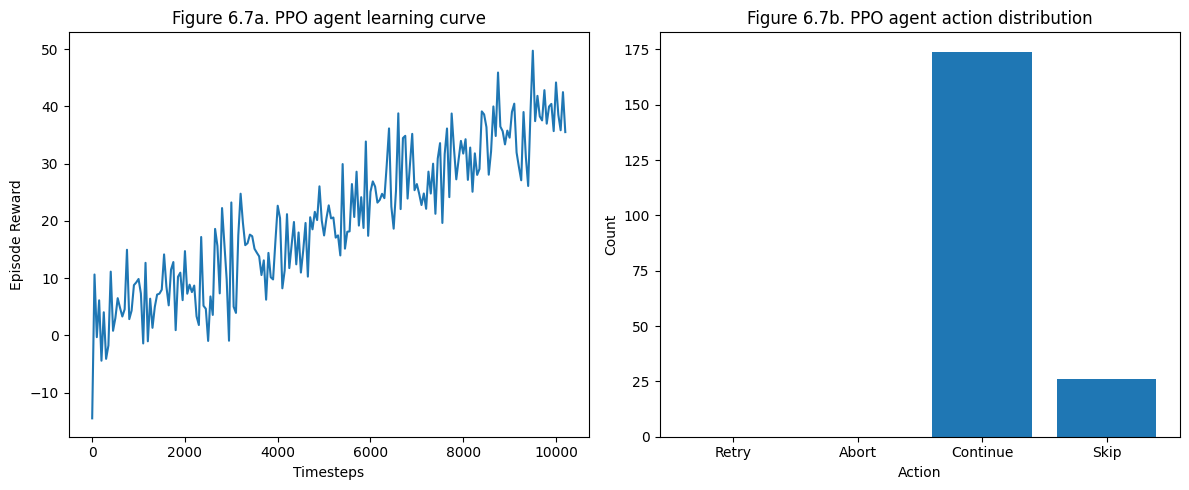

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# --- Simulated data (replace with your arrays if available) ---
timesteps = np.arange(0, 10240, 50)
episode_rewards = np.random.normal(loc=np.linspace(0, 40, len(timesteps)), scale=5)

actions = ["Retry"]*0 + ["Abort"]*0 + ["Continue"]*174 + ["Skip"]*26
action_labels = ["Retry", "Abort", "Continue", "Skip"]
action_counts = [actions.count(a) for a in action_labels]

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Figure 6.7a - Learning curve
axes[0].plot(timesteps, episode_rewards, color="tab:blue")
axes[0].set_title("Figure 6.7a. PPO agent learning curve")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Episode Reward")

# Figure 6.7b - Action distribution
axes[1].bar(action_labels, action_counts, color="tab:blue")
axes[1].set_title("Figure 6.7b. PPO agent action distribution")
axes[1].set_xlabel("Action")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
